# Identifying Underpriced Properties

In this notebook I'll be demonstrating some of the techniques used in this project in order to identify a set of underpriced properties in the dataset. We'll use several different base models, then use these base predictions for a set of stacked models, finally we can use some data processing techniques in order to use the best available data to generate our final predictions.

We start off by loading the data and applying the same processing techniques as we did in the clustering notebook, in order to prepare the data as an input for our models. We can then separate our data from target column 'saleEstimate_currentPrice', from the rest of the columns available in the set.

In [50]:
import pandas as pd,numpy as np, processing, utils

data = pd.read_csv("data/kaggle_london_house_price_data.csv")
rawTargets = data['saleEstimate_currentPrice'].copy() # Keep a copy of the non-normalized target prices

data, info = processing.processData(data)

data = data.sample(5000)
y_data = data['saleEstimate_currentPrice']
x_data = data[['latitude', 'longitude', 'floorAreaSqM', 'bedrooms_2.0', 'bedrooms_3.0', 'bedrooms_4.0', 'bedrooms_5.0', 'bedrooms_6.0', 'bedrooms_7.0', 'bedrooms_8.0', 'bedrooms_9.0','bedrooms_Unknown',
    'livingRooms_2.0', 'livingRooms_3.0', 'livingRooms_4.0', 'livingRooms_5.0', 'livingRooms_6.0', 'livingRooms_7.0', 'livingRooms_8.0', 'livingRooms_9.0', 'livingRooms_Unknown',
    'tenure_Freehold', 'tenure_Leasehold', 'tenure_Shared', 'tenure_Unknown',
    'propertyType_Converted Flat', 'propertyType_Detached Bungalow', 'propertyType_Detached House', 'propertyType_Detached Property', 'propertyType_End Terrace Bungalow', 'propertyType_End Terrace House', 'propertyType_End Terrace Property', 'propertyType_Flat/Maisonette', 'propertyType_Mid Terrace Bungalow', 'propertyType_Mid Terrace House', 'propertyType_Mid Terrace Property', 'propertyType_Purpose Built Flat', 'propertyType_Semi-Detached Bungalow', 'propertyType_Semi-Detached House', 'propertyType_Semi-Detached Property', 'propertyType_Terrace Property', 'propertyType_Terraced', 'propertyType_Terraced Bungalow', 'propertyType_Unknown']].copy()

Dropping Index(['bathrooms', 'currentEnergyRating', 'history_percentageChange',
       'history_numericChange'],
      dtype='object')


With our data ready to go, we can initiate our selected models for our first set of predictions. Our random forest and xgboost models track the importance of each feature from the input so we'll create a dictionary to look at these values later. The models are trained using our input and target data, then a set of predictions for each model is stored in our dataframe. As a simple sanity check we can create a heatmap of the prediction correlations in order to check the degree of consensus between our models.

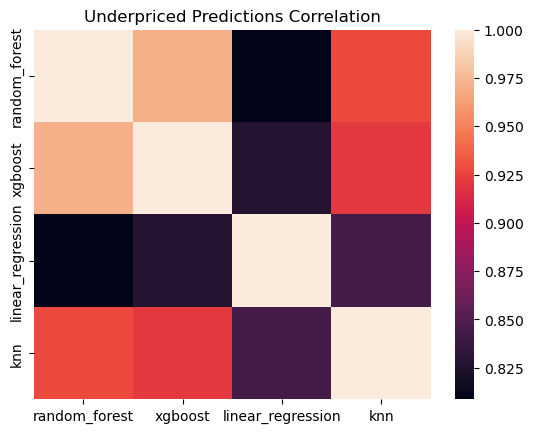

                               features             1         2       average
2                          floorAreaSqM  5.258779e-01  0.256736  3.913071e-01
1                             longitude  2.010610e-01  0.065185  1.331230e-01
0                              latitude  1.481193e-01  0.043731  9.592492e-02
9                          bedrooms_8.0  1.776998e-02  0.091455  5.461225e-02
16                      livingRooms_6.0  1.534309e-02  0.068168  4.175575e-02
36      propertyType_Purpose Built Flat  3.253668e-03  0.059723  3.148809e-02
22                     tenure_Leasehold  5.171377e-03  0.050433  2.780225e-02
15                      livingRooms_5.0  7.122950e-03  0.043640  2.538130e-02
32         propertyType_Flat/Maisonette  7.514328e-03  0.032093  1.980368e-02
13                      livingRooms_3.0  9.213972e-03  0.029817  1.951549e-02
7                          bedrooms_6.0  5.306393e-03  0.033555  1.943092e-02
20                  livingRooms_Unknown  2.822736e-03  0.034974 

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

def getModelPredictions(model, xData: pd.DataFrame, yData: pd.DataFrame, featureDf: dict = None):
    model.fit(xData, yData)
    predictedPrice = model.predict(xData)

    if hasattr(model, 'feature_importances_'):
        featureDf[str(len(featureDf))] = model.feature_importances_

    return predictedPrice

featureDf = {'features': x_data.columns}
predsDf = pd.DataFrame({
    'random_forest': getModelPredictions(RandomForestRegressor(), x_data, y_data, featureDf),
    'xgboost': getModelPredictions(XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0), x_data, y_data, featureDf),
    'linear_regression': getModelPredictions(LinearRegression(), x_data, y_data),
    'knn': getModelPredictions(KNeighborsRegressor(), x_data, y_data)
})
utils.buildHeatmap(predsDf.corr(), "Underpriced Predictions Correlation", xTitle="", yTitle="")



def showFeatures(featureDf: pd.DataFrame):
    featureDf['average'] = featureDf.iloc[:, 1:].mean(axis=1)
    featureDf = featureDf.sort_values(by='average', ascending=False)
    print(featureDf)

showFeatures(pd.DataFrame(featureDf))

We're getting a pretty high degree of correlation between each of our prediction sets, indicating that our models have each learned correctly, we also see from our features dataframe which fields contribute most significantly to the predictions from two of our models.

However instead of using these predictions to directly generate our final list of underpriced properties, we can stack another set of models on top of these predictions, using these predicted values as the training data for our next set of models, to see if we can get better results. Before we do so, we can evaluate the accuracy of our current models, and augment our data by creating two new columns which combine our existing results. To do this we'll first generate a simple average predicted value from each of the four models, then caluclate the RMS error of each model and use that to assign that set of predictions a weight in order to generate a weighted average column for our final input dataframe to our set of stacked models.

In [52]:
def getRmseWeights(y_data: pd.Series, predsDf: pd.DataFrame) -> np.ndarray:
    rmseList = []
    for _, preds in predsDf.items():
        rmseList.append(root_mean_squared_error(y_data, preds))

    invErrors = 1 / np.array(rmseList)
    return invErrors / invErrors.sum(), rmseList

def addCols(y_data: pd.Series, predsDf: pd.DataFrame, verbal: bool = True, n: int = 5):
    predWeights, rmseList = getRmseWeights(y_data, predsDf)
    print(f"Prediction Weights: {predWeights}")
    predsDf['weighted_avg'] = predsDf.dot(predWeights)
    predsDf['avg_price_diff'] = predsDf.mean(axis=1)

    for col in predsDf.iloc[:, -2:]:
        rmseList.append(root_mean_squared_error(y_data, predsDf[col]))

    if verbal:
        mseDict = {}
        for i, colName in enumerate(predsDf.columns):
            mseDict[colName] = round(rmseList[i] ** 2, n)
        print(mseDict)
    
    return rmseList

rmseValues = addCols(y_data, predsDf, verbal=True, n=5) # Augment data with average and weighted average predictions

Prediction Weights: [0.43499884 0.25941197 0.12741749 0.1781717 ]
{'random_forest': 0.02867, 'xgboost': 0.08062, 'linear_regression': 0.33415, 'knn': 0.17089, 'weighted_avg': 0.06749, 'avg_price_diff': 0.09474}


We can now read the accuracy of each of the models we have used up to this point, and successfully created some extra columns for our next set of models. Before we continue we can scale our predicted data before using it as an input, the repeating the training process with a set of stacked models.

In [53]:
scaler = StandardScaler()
scaledPredsDf = pd.DataFrame(scaler.fit_transform(predsDf), columns=predsDf.columns)

stackedFeatureDf = {'features': scaledPredsDf.columns}
stackedPredsDf = pd.DataFrame({
    'random_forest': getModelPredictions(RandomForestRegressor(), scaledPredsDf, y_data, stackedFeatureDf),
    'xgboost': getModelPredictions(XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=0), scaledPredsDf, y_data, stackedFeatureDf),
    'linear_regression': getModelPredictions(LinearRegression(), scaledPredsDf, y_data),
    'knn': getModelPredictions(KNeighborsRegressor(), scaledPredsDf, y_data)
})

rmseList = addCols(y_data, stackedPredsDf, verbal=True, n=5)
showFeatures(pd.DataFrame(stackedFeatureDf))
print(stackedPredsDf.head())

Prediction Weights: [0.40701658 0.2656128  0.16031901 0.16705161]
{'random_forest': 0.00317, 'xgboost': 0.00744, 'linear_regression': 0.02042, 'knn': 0.0188, 'weighted_avg': 0.00647, 'avg_price_diff': 0.0082}
            features         1         2   average
0      random_forest  0.973498  0.964777  0.969138
1            xgboost  0.012151  0.008893  0.010522
2  linear_regression  0.005792  0.008710  0.007251
3                knn  0.003574  0.007007  0.005290
5     avg_price_diff  0.002311  0.006505  0.004408
4       weighted_avg  0.002675  0.004107  0.003391
   random_forest   xgboost  linear_regression       knn  weighted_avg  \
0      -0.145496 -0.124571          -0.120680 -0.116831     -0.131171   
1       0.356215  0.337432           0.330121  0.409524      0.355948   
2      -0.535220 -0.521693          -0.534798 -0.520399     -0.529084   
3       5.613113  5.990844           5.260271  5.736748      5.677529   
4      -0.580499 -0.584307          -0.583928 -0.594071     -0.584328

We can see from our printed mse values that these stacked models have performed much better than our original set of models, we'll choose the best set of predictions then use that to create our final properties of interest.

We can also use our rawTarget values to convert our normalized predictions back to the original real-price scale, in order to generate some more intuitive metrics using these final predictions.

Best column: random_forest with RMSE: 0.05627959296885886


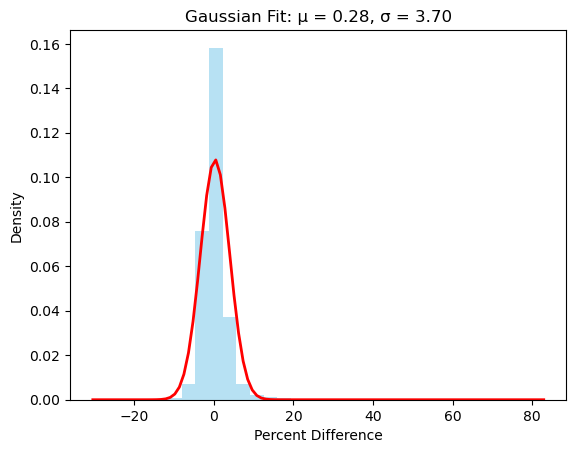

In [54]:
bestColumn = stackedPredsDf.columns[rmseList.index(min(rmseList))]
print(f"Best column: {bestColumn} with RMSE: {min(rmseList)}")

descaledPreds = stackedPredsDf.drop(['weighted_avg', 'avg_price_diff'], axis=1) * rawTargets.std() + rawTargets.mean()
descaledPreds.index = y_data.index
y = rawTargets[y_data.index]

percentDiff = descaledPreds.subtract(y, axis=0).div(y, axis=0) * 100
utils.plotGaussian(percentDiff[bestColumn])

With our final set of predictions and ground truth data prepared, we can now determine our best predictions for underpriced properties. To do so we select rows where are predictions are the largest relative to their ground truth values, which implies that according to the characteristics of the dataset learned by our model these properties should be priced higher.

From the generated gaussian curve, which shows the distribution of our 'Overpriced %' metric, we see that the vast majority of predictions fall very close to their real values, indicating that our model can reliably predict accurate prices, we also see that very few properties fall outside of the +/- 10% range from our target price.

We could go ahead and make our final selection of underpriced properties based off this selected model's set of predictions, however that method would be completely dependent on that model's output and is vulnerable to any outlying and misleading predictions from that model. To get a more safe and complete picture which takes into account the entire set of predictions while still prioritizing our leading model's output, I developed a formula to create a final column to be used as our ultimate means of selecting our list of underpriced properties.

In [55]:
import folium

def genlabelFeatures(data: pd.DataFrame, colName: str) -> dict:
    labelFeatures = {}
    for label in enumerate(data[colName].unique()):
        labelFeatures[label[1]] = folium.FeatureGroup(name=label[1])
    
    return labelFeatures


c1, c2, topN = 10, 10, 0.01

percentDiff = percentDiff[percentDiff[bestColumn] > 0] # Only considering underpriced predictions from best model

altCols = percentDiff.columns.drop(bestColumn)
predWeights = getRmseWeights(pd.Series(np.zeros((len(percentDiff)))), percentDiff[altCols])[0]

# Calculate consensus and confidence score based on alternative columns
percentDiff['alt_col_weighted_avg'] = percentDiff[altCols].dot(predWeights)
percentDiff['std'] = percentDiff[altCols].std(axis=1)
percentDiff['consensus_score'] = c1 * abs(percentDiff['alt_col_weighted_avg'] - percentDiff[bestColumn]) / percentDiff[bestColumn] + c2 * (percentDiff['std'] / abs(percentDiff['alt_col_weighted_avg']))
percentDiff['combined_score'] = percentDiff[bestColumn] - percentDiff['consensus_score']
percentDiff.sort_values(by='combined_score', ascending=False, inplace=True)
percentDiff['confidence'] = pd.qcut(percentDiff['consensus_score'], 4, labels=['High', 'Medium', 'Low', 'Disagree'])

print(percentDiff.head(10))

        random_forest     xgboost  linear_regression         knn  \
121929      77.765079    5.309236         186.865049   76.539683   
245386      53.962688   51.255760          45.632430   46.644407   
24917       56.992806  106.408993         143.583201  113.848921   
267676      47.637969   12.433009          88.242205  224.591611   
383100      33.763393   21.897345          68.518665   48.979592   
183158      37.675817   56.357647          94.984921   89.019608   
365136      30.789107   14.118344          61.287377   52.984749   
30917       29.152961   42.456168          54.484406   22.434211   
74178       31.211082   38.933658          82.501973   49.815303   
86380       35.046455   39.040709         129.772537   95.012225   

        alt_col_weighted_avg         std  consensus_score  combined_score  \
121929             78.236406   91.476751        11.752960       66.012119   
245386             48.292568    2.997513         1.671447       52.291241   
24917             11

The method re-uses our getRmseWeights function to generate a set of weights for each of our secondary models, which is used to generate a weighted average for each entry. We also take the standard deviation of these secondary columns. We then create a "Consensus Score" column, which calculates the difference between the initial prediction and the secondary weighted average, normalized by the initial prediction, as well as the standard deviation of the secondary columns, normalized by the weighted average. This value is used as a penalty score which targets predictions that are either not supported by the secondary models, or for which there is not a strong consensus among the secondary models. This score is then subtracted from our initial predicted value in order to generate our final ranking of underpriced properties.

We can finally add these metrics to our informational dataframe to be displayed. We'll be displaying these final selected properties on a map, and to make it a little more readable we can sort the data into separate categories according to the calculated overpriced % value.

In [56]:
# Set additional info for mapping
percentDiff = percentDiff.head(round(len(percentDiff) * topN))
info = info.loc[percentDiff.index]
info['Predicted Price'] = round(descaledPreds[bestColumn], 2)
info.loc[percentDiff.index, 'Underpriced %'] = round(percentDiff[bestColumn], 2)
info.loc[percentDiff.index, 'Confidence'] = percentDiff['confidence']

info['label'] = pd.cut(info['Underpriced %'], bins=[0, 10, 20, 30, 40, 50, np.inf], labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50+'])
labelFeatures = genlabelFeatures(info, 'label')
utils.mapLabelledGroups(info, 'underpriced_properties', labelFeatures, info['latitude'].mean(), info['longitude'].mean(), len(info), 'anomalies', 'label', saveFlag=False)

Using this data we generated an interactive map listing the properties most likely to be underpriced as predicted by our model. By using the stacked model structure we were able to greatly increase the accuracy of our predictions, by using the our consensus process we were able to penalize any outlying predictions from our primary model, and take into account information from each of the final models.

It's important to note that the predictions that we have are only as good as the data that we used, and there may be any number of real-world reasons that the properties are not priced as we predicted with our model. However techniques such as the ones we have used here are a great place to start for further analysis if one is interested in trying to capture outliers in a real-world market.